# Canonical Correlation Analysis (CCA)
Here I calculate the Canonical Correlation Coefficients and the canonical variables for the two datasets. 
I also plot the correlation coefficients and the canonical variables.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cross_decomposition import CCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
# Parameters
cell_type = "SHSY5Y"
Shuffle = False

In [3]:
# set paths to data
morphology_data_path = pathlib.Path(
    f"../../data/{cell_type}_preprocessed_sc_norm_aggregated.parquet"
).resolve(strict=True)
nomic_data_path = pathlib.Path(
    f"../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_{cell_type}_clean.parquet"
).resolve(strict=True)

# output path
results_file_path = pathlib.Path(f"../results/{cell_type}_redundancy_analysis.csv")
results_file_path.parent.mkdir(parents=True, exist_ok=True)

# read data
morphology_data = pd.read_parquet(morphology_data_path)
nomic_data = pd.read_parquet(nomic_data_path)

In [4]:
# get the columns that contain metadata
morphology_metadata = morphology_data[
    morphology_data.columns[morphology_data.columns.str.contains("Metadata")]
]
morphology_data = morphology_data.drop(morphology_metadata.columns, axis=1)

nomic_data_values = nomic_data[
    nomic_data.columns[nomic_data.columns.str.contains("[NSU]", regex=True)]
]
nomic_metadata = nomic_data.drop(nomic_data_values.columns, axis=1)

In [5]:
# standardize the data for nomic standard scalar
scaler = StandardScaler()
nomic_data_values = scaler.fit_transform(nomic_data_values)
nomic_data_values = pd.DataFrame(
    nomic_data_values,
    columns=nomic_data.columns[nomic_data.columns.str.contains("[NSU]", regex=True)],
)

In [6]:
# check the scale of the data
nomic_data_values.describe()

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,TWEAK [NSU],uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU]
count,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,...,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02
mean,-5.767392e-18,2.537653e-16,-1.586033e-17,-2.883696e-16,-4.210196e-16,-3.460435e-16,-6.949708e-16,8.074349e-17,-1.672544e-16,-2.710674e-16,...,5.767392e-17,-6.920871e-17,1.023712e-16,-4.412055e-16,-5.306001e-16,1.874403e-16,1.845566e-16,-2.220446e-16,-4.498566e-16,1.845566e-16
std,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,...,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00
min,-2.691866e+00,-2.696353e+00,-2.237568e+00,-2.456348e+00,-2.837719e+00,-2.684119e+00,-3.451689e+00,-3.569405e+00,-2.629060e+00,-2.635962e+00,...,-2.365982e+00,-1.483717e+00,-2.251355e+00,-2.502359e+00,-2.476014e+00,-2.028581e+00,-2.933628e+00,-2.575479e+00,-2.707078e+00,-2.665481e+00
25%,-7.382462e-01,-6.940149e-01,-7.268042e-01,-6.476923e-01,-6.716020e-01,-7.260002e-01,-5.677978e-01,-6.072838e-01,-6.428204e-01,-6.966886e-01,...,-7.332631e-01,-6.026020e-01,-7.454492e-01,-6.688754e-01,-6.648255e-01,-6.218562e-01,-6.166921e-01,-5.960095e-01,-6.397282e-01,-6.772764e-01
50%,-7.722240e-02,-3.012511e-02,1.418990e-02,9.647868e-02,8.166907e-02,-4.792004e-02,2.800882e-02,6.682614e-02,3.158489e-02,6.926583e-02,...,-3.425331e-02,-2.746469e-01,-3.635448e-02,-3.673122e-02,-3.618958e-02,-3.428984e-02,-2.668467e-02,3.575778e-02,-8.369562e-02,-3.026831e-02
75%,6.461317e-01,7.332197e-01,6.070213e-01,6.230867e-01,7.491312e-01,6.578601e-01,5.727327e-01,6.151911e-01,6.890445e-01,6.578658e-01,...,6.076744e-01,3.022558e-01,6.476946e-01,6.489825e-01,6.997961e-01,3.930677e-01,6.191390e-01,6.505894e-01,8.313301e-01,7.287864e-01
max,2.557580e+00,2.202141e+00,4.555992e+00,2.548749e+00,2.671947e+00,3.454775e+00,2.866139e+00,3.064857e+00,2.550136e+00,3.315288e+00,...,3.341457e+00,4.055895e+00,3.050163e+00,2.921248e+00,2.564062e+00,5.374768e+00,3.222332e+00,2.501835e+00,2.604819e+00,2.220510e+00


In [7]:
# shuffle the data both rows and columns
if Shuffle:
    for column in nomic_data_values:
        np.random.shuffle(nomic_data_values[column].values)
    for column in morphology_data:
        np.random.shuffle(morphology_data[column].values)

### Variables
$Y_{M \times P} = MorphologyData$  
$X_{N \times Q} = NomicData$  
Where  
$M = Rows of MorphologyData$  
$P = Columns of MorphologyData$  
$N = Rows of NomicData$  
$Q = Columns of NomicData$  

In [8]:
# define the variables
N = morphology_data.shape[0]
P = morphology_data.shape[1]

N = nomic_data_values.shape[0]
Q = nomic_data_values.shape[1]
print("N:", N, "P:", P, "Q:", Q)
K = min(N, P, Q)
print("K:", K)

N: 154 P: 1251 Q: 187
K: 154


In [9]:
cca = CCA(n_components=K)
cca.fit(morphology_data, nomic_data_values)
X_c, Y_c = cca.transform(morphology_data, nomic_data_values)
r2 = [cca.score(morphology_data, nomic_data_values), X_c, Y_c][0]
print("The R2 score for the Canonical Correlation is:", r2)

The R2 score for the Canonical Correlation is: 0.1549824908098266


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 153
  warnings.warn(f"Y residual is constant at iteration {k}")


In [10]:
A_tilde = cca.x_loadings_.T
B_tilde = cca.y_loadings_.T

From the canonical coefficients we can calculate the variance extracted by each canonical variable.  
$u_k = \frac{1}{P} \sum^P_{p=1} \tilde a^2_{pk}$  
  
$v_k = \frac{1}{Q} \sum^Q_{q=1} \tilde a^2_{qk}$

In [11]:
u_k = []
v_k = []
for i in A_tilde:
    u_k.append(np.mean(i**2))
for i in B_tilde:
    v_k.append(np.mean(i**2))

In [12]:
# coefficients of determination for each canonical variable
r2 = r2_score(u_k, v_k)

In [13]:
# calculate the redundancy index for each canonical variable
RI_u = []
RI_v = []

for i in u_k:
    RI_u.append(i * r2)
for i in v_k:
    RI_v.append(i * r2)

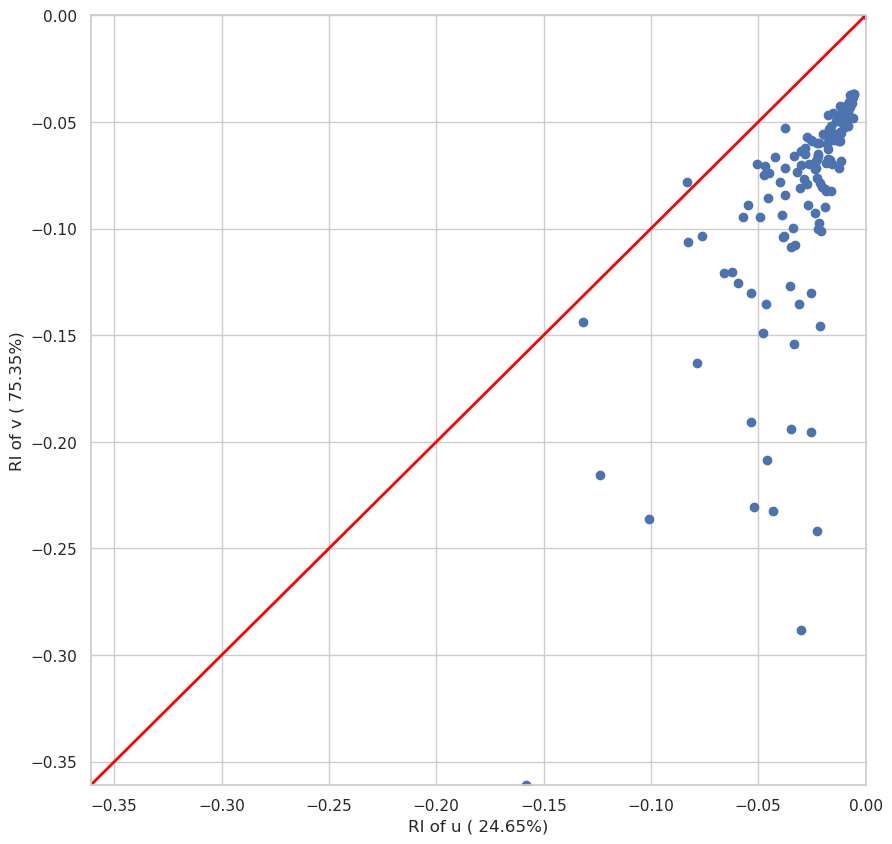

In [14]:
RI_u_min = np.min(RI_u)
RI_v_min = np.min(RI_v)
RI_u_max = np.max(RI_u)
RI_v_max = np.max(RI_v)
global_min = np.min([RI_u_min, RI_v_min])
global_max = np.max([RI_u_max, RI_v_max])

# Calulate the global redundancy index
global_RI_u_v = np.sum(RI_u) + np.sum(RI_v)
global_RI_u = np.sum(RI_u) / global_RI_u_v * 100
global_RI_v = np.sum(RI_v) / global_RI_u_v * 100

# plot RI_u and RI_v
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 10))
plt.scatter(RI_u, RI_v)
plt.xlabel(f"RI of u ( {round(global_RI_u,2)}%)")
plt.ylabel(f"RI of v ( {round(global_RI_v,2)}%)")
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
# add a line of y=x to the plot
plt.plot(
    [global_min, global_max],
    [global_min, global_max],
    color="red",
    linestyle="-",
    linewidth=2,
)

In [15]:
# make a dataframe of the results
results_df = pd.DataFrame(
    {
        "RI_u": RI_u,
        "RI_v": RI_v,
        "u_k": u_k,
        "v_k": v_k,
        "r2": r2,
        "Shuffle": Shuffle,
    }
)

results_df.head(5)

,RI_u,RI_v,u_k,v_k,r2,Shuffle
0,-0.022901,-0.068289,0.003336,0.009947,-6.865314,False
1,-0.100897,-0.236104,0.014697,0.034391,-6.865314,False
2,-0.066115,-0.120811,0.009630,0.017597,-6.865314,False
3,-0.158201,-0.361020,0.023043,0.052586,-6.865314,False
4,-0.032683,-0.107614,0.004761,0.015675,-6.865314,False


In [16]:
# check for file existence
if results_file_path.is_file():
    print("The results file exists.")
    #  read the results file
    existing_file_df = pd.read_csv(results_file_path)
    # check for if it is full for shuffle type
    if len(existing_file_df["Shuffle"].unique()) > 1:
        # delete the existing file
        results_file_path.unlink()
    elif not existing_file_df["Shuffle"].unique() == Shuffle:
        pd.concat([existing_file_df, results_df]).to_csv(results_file_path, index=False)
else:
    results_df.to_csv(results_file_path, index=False)
    print("The results file is created.")

The results file exists.
